In [40]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

# Load Data

In [41]:
seed = 42

In [42]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [43]:
label_dict = {
    # Controls
    'n': 0,
    # Chirrhosis
    'cirrhosis': 1,
    # Colorectal Cancer
    'cancer': 1, 'small_adenoma': 0,
    # IBD
    'ibd_ulcerative_colitis': 1, 'ibd_crohn_disease': 1,
    # T2D and WT2D
    't2d': 1,
    # Obesity
    'leaness': 0, 'obesity': 1,
}
def loadData(data_dir, filename, dtype=None):
    feature_string = ''
    if filename.split('_')[0] == 'abundance':
        feature_string = "k__"
    if filename.split('_')[0] == 'marker':
        feature_string = "gi|"
    # read file
    filename = data_dir + filename
    if not os.path.isfile(filename):
        print("FileNotFoundError: File {} does not exist".format(filename))
        exit()
    raw = pd.read_csv(filename, sep='\t', index_col=0, header=None)

    # select rows having feature index identifier string
    X = raw.loc[raw.index.str.contains(feature_string, regex=False)].T

    # get class labels
    Y = raw.loc['disease']
    Y = Y.replace(label_dict)

    # train and test split
    X_train, X_test, y_train, y_test = train_test_split(X.values.astype(dtype), Y.values.astype('int'), test_size=0.2, random_state=seed, stratify=Y.values)
    print("Train data shape: ", X_train.shape)
    print("Test data shape: ", X_test.shape)
    return X_train, X_test, y_train, y_test

data_dir = '../data/abundance/'
data_string = 'abundance_Cirrhosis.txt'
X_train, X_test, y_train, y_test = loadData(data_dir, data_string, dtype='float32')

Train data shape:  (185, 542)
Test data shape:  (47, 542)


In [44]:
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=32, shuffle=False)

# Define the VAE model

In [45]:
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, latent_dim=8):
        super(VAE, self).__init__()
        self.input_dim = input_dim

        # DNN as encoder
        self.encoder1 = nn.Linear(input_dim, 128)
        self.mu = nn.Linear(128, 8)
        self.log_sigma2 = nn.Linear(128, 8)

        # DNN as decoder
        self.decoder1 = nn.Linear(8, 128)
        self.decoder2 = nn.Linear(128, input_dim)

    def encoder(self, x):
        h = torch.tanh(self.encoder1(x))
        return self.mu(h), torch.sqrt(torch.exp(self.log_sigma2(h)))

    def sampling(self, mu, std): # Reparameterization trick
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = torch.tanh(self.decoder1(z))
        return torch.sigmoid(self.decoder2(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, self.input_dim))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

    @staticmethod
    def loss_func(x_hat, x, mu, std):
        # define the reconstruction loss
        ERR = F.binary_cross_entropy(x_hat, x, reduction='sum')
        # define the KL divergence loss
        KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
        return ERR + KLD, ERR, KLD

model = VAE(input_dim=X_train.shape[1], latent_dim=8)
model.to(device) # move model to GPU

VAE(
  (encoder1): Linear(in_features=542, out_features=128, bias=True)
  (mu): Linear(in_features=128, out_features=8, bias=True)
  (log_sigma2): Linear(in_features=128, out_features=8, bias=True)
  (decoder1): Linear(in_features=8, out_features=128, bias=True)
  (decoder2): Linear(in_features=128, out_features=542, bias=True)
)

# Model training and evaluation

In [46]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

rec_loss, kl_loss = [], []
for epoch in range(50):

    """ model training """
    model.train()
    cur_rec_loss, cur_kl_loss = [], []
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        rec, mu, std = model(data)
        loss, err, kl = model.loss_func(rec, data.reshape(-1, model.input_dim), mu, std)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cur_rec_loss.append(err.item())
        cur_kl_loss.append(kl.item())

    rec_loss.append(np.mean(cur_rec_loss))
    kl_loss.append(np.mean(cur_kl_loss))

    """ model evaluation """
    with torch.no_grad():
        test_loss = []
        for batch_idx, (data, _) in enumerate(testloader):
            data = data.to(device)
            rec, mu, std = model(data)
            _, mse, _ = model.loss_func(rec, data.reshape(data.shape[0], -1), mu, std)
            test_loss.append(mse.item())

    if epoch % 10 == 0:
        print (f"-- epoch {epoch} --, train MSE: {np.mean(cur_rec_loss)}, train KL: {np.mean(cur_kl_loss)}, test MSE: {np.mean(test_loss)}")

-- epoch 0 --, train MSE: 11262.017252604166, train KL: 36.26022752126058, test MSE: 7843.613525390625
-- epoch 10 --, train MSE: -7535.48779296875, train KL: 945.6102905273438, test MSE: -6517.487060546875
-- epoch 20 --, train MSE: -42021.263671875, train KL: 872.8953145345052, test MSE: -45841.912109375
-- epoch 30 --, train MSE: -121088.40104166667, train KL: 386.58494059244794, test MSE: -102533.69921875
-- epoch 40 --, train MSE: -127408.85807291667, train KL: 348.8780517578125, test MSE: -87165.74609375


# Draw Loss and Accuracy Curves

Text(0.5, 1.0, 'KL divergence loss')

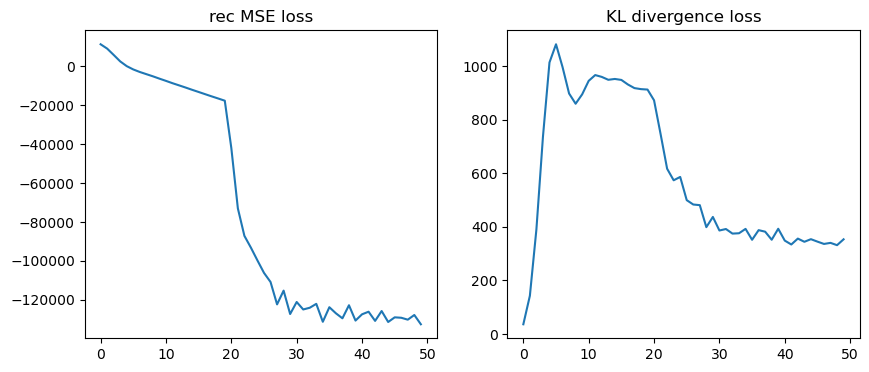

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(rec_loss)
plt.title("rec MSE loss")

plt.subplot(122)
plt.plot(kl_loss)
plt.title("KL divergence loss")

# Transform the data by using the trained model

In [48]:
X_train = torch.tensor(X_train).to(device)
X_test = torch.tensor(X_test).to(device)

X_train_encoded = model.encoder(X_train)[0].cpu().detach().numpy()
X_test_encoded = model.encoder(X_test)[0].cpu().detach().numpy()

# Classification by using the transformed data

In [49]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
def get_metrics(clf, is_svm=False):
    y_true, y_pred = y_test, clf.predict(X_test_encoded)
    y_prob = 0
    if is_svm:
        y_prob = clf.decision_function(X_test_encoded)
    else:
        y_prob = clf.predict_proba(X_test_encoded)
    # Performance Metrics: AUC, ACC, Recall, Precision, F1_score
    metrics = {
    'ACC': accuracy_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred),
    'F1_score': f1_score(y_true, y_pred),
    }
    if not is_svm:
        metrics['AUC'] = roc_auc_score(y_true, y_prob[:, 1])
    else:
        metrics['AUC'] = roc_auc_score(y_true, y_prob)
    return metrics

In [50]:
# SVM
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf, is_svm=True))

{'ACC': 0.7021276595744681, 'Recall': 0.625, 'Precision': 0.75, 'F1_score': 0.6818181818181818, 'AUC': 0.8405797101449275}


In [51]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf))

{'ACC': 0.7872340425531915, 'Recall': 0.6666666666666666, 'Precision': 0.8888888888888888, 'F1_score': 0.761904761904762, 'AUC': 0.8442028985507247}


In [52]:
# Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf))

{'ACC': 0.7021276595744681, 'Recall': 0.625, 'Precision': 0.75, 'F1_score': 0.6818181818181818, 'AUC': 0.8079710144927537}


/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
